In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})
display(data)

,x,y
0,-10.000000,1
1,-8.965517,1
2,-7.931034,3
3,-6.896552,3
4,-5.862069,1
5,-4.827586,8
6,-3.793103,8
7,-2.758621,10
8,-1.724138,13
9,-0.689655,12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


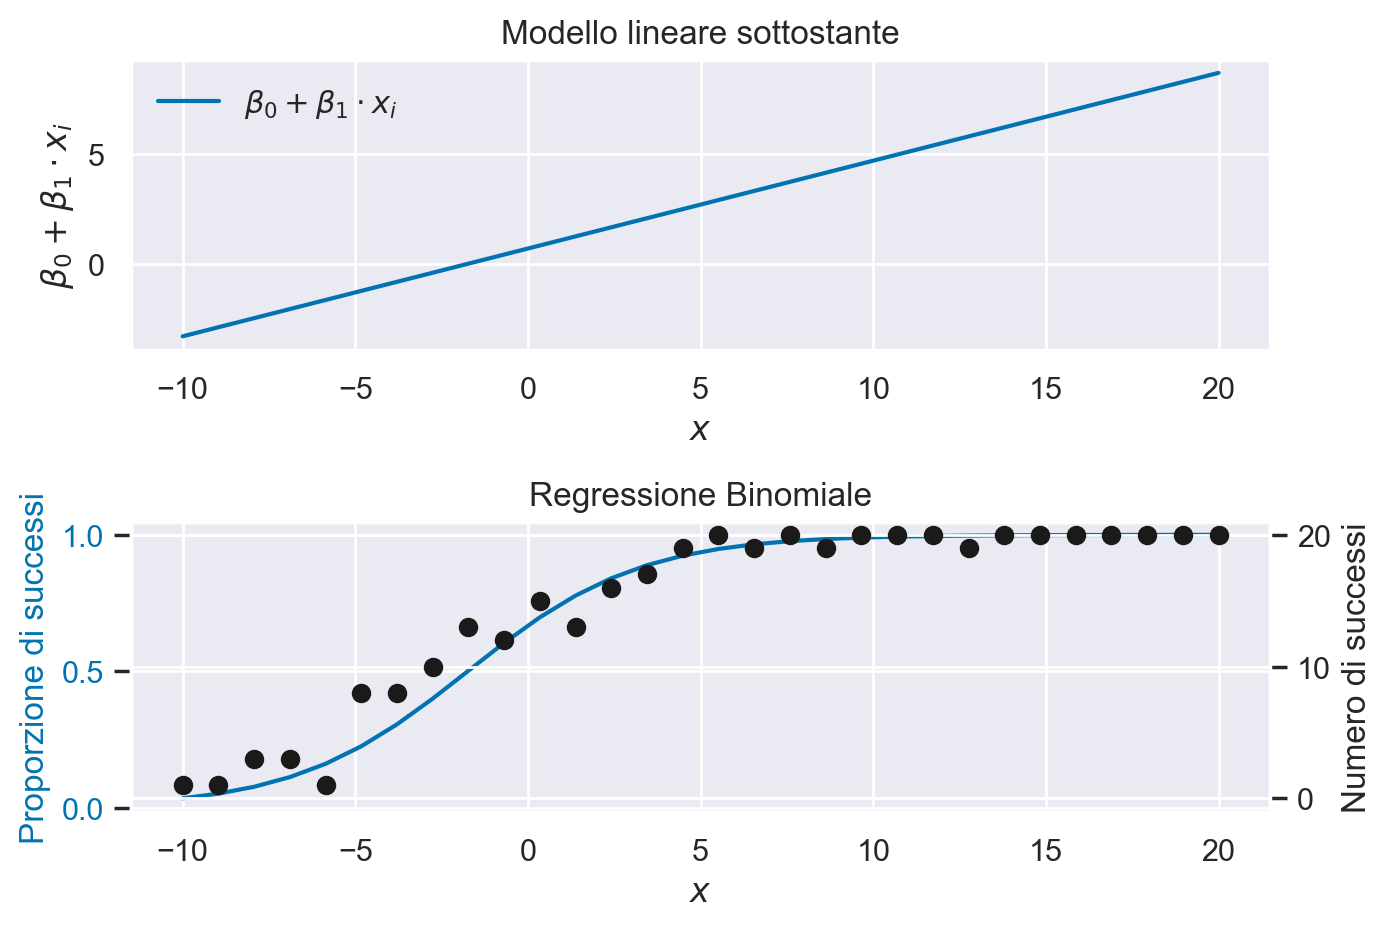

In [4]:
# Grafico del modello lineare sottostante
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(x, mu_true, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("$x$")
plt.ylabel(r"$\beta_0 + \beta_1 \cdot x_i$")
plt.title("Modello lineare sottostante")
plt.legend()

# Grafico della Regressione Binomiale
plt.subplot(2, 1, 2)
plt.plot(x, p_true, label=r"$g^{-1}(\beta_0 + \beta_1 \cdot x_i)$", color="b")
plt.ylabel("Proporzione di successi", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.xlabel("$x$")
plt.title("Regressione Binomiale")

# get y-axes to line up
y_buffer = 1

# Secondo asse y per il numero di successi
plt2 = plt.twinx()
plt2.scatter(x, y, color="k")
plt2.set_ylabel("Numero di successi")
plt2.set_ylim([-y_buffer, n + y_buffer])

plt.legend()
plt.tight_layout()
plt.show()

In [5]:
coords = {"observation": data.index.values}
print(coords)

{'observation': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}


In [6]:
with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

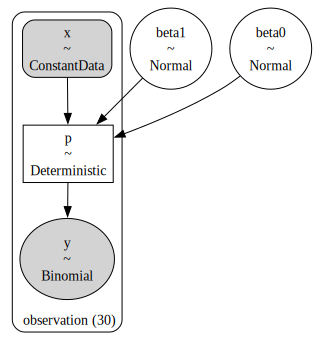

In [7]:
pm.model_to_graphviz(binomial_regression_model)

In [8]:
with binomial_regression_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:02.794242


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1382.60it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1383.77it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1384.91it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1386.06it/s]


Sampling time = 0:00:01.777615


Transforming variables...


Transformation time = 0:00:00.088368


Computing Log Likelihood...


Log Likelihood time = 0:00:00.166974


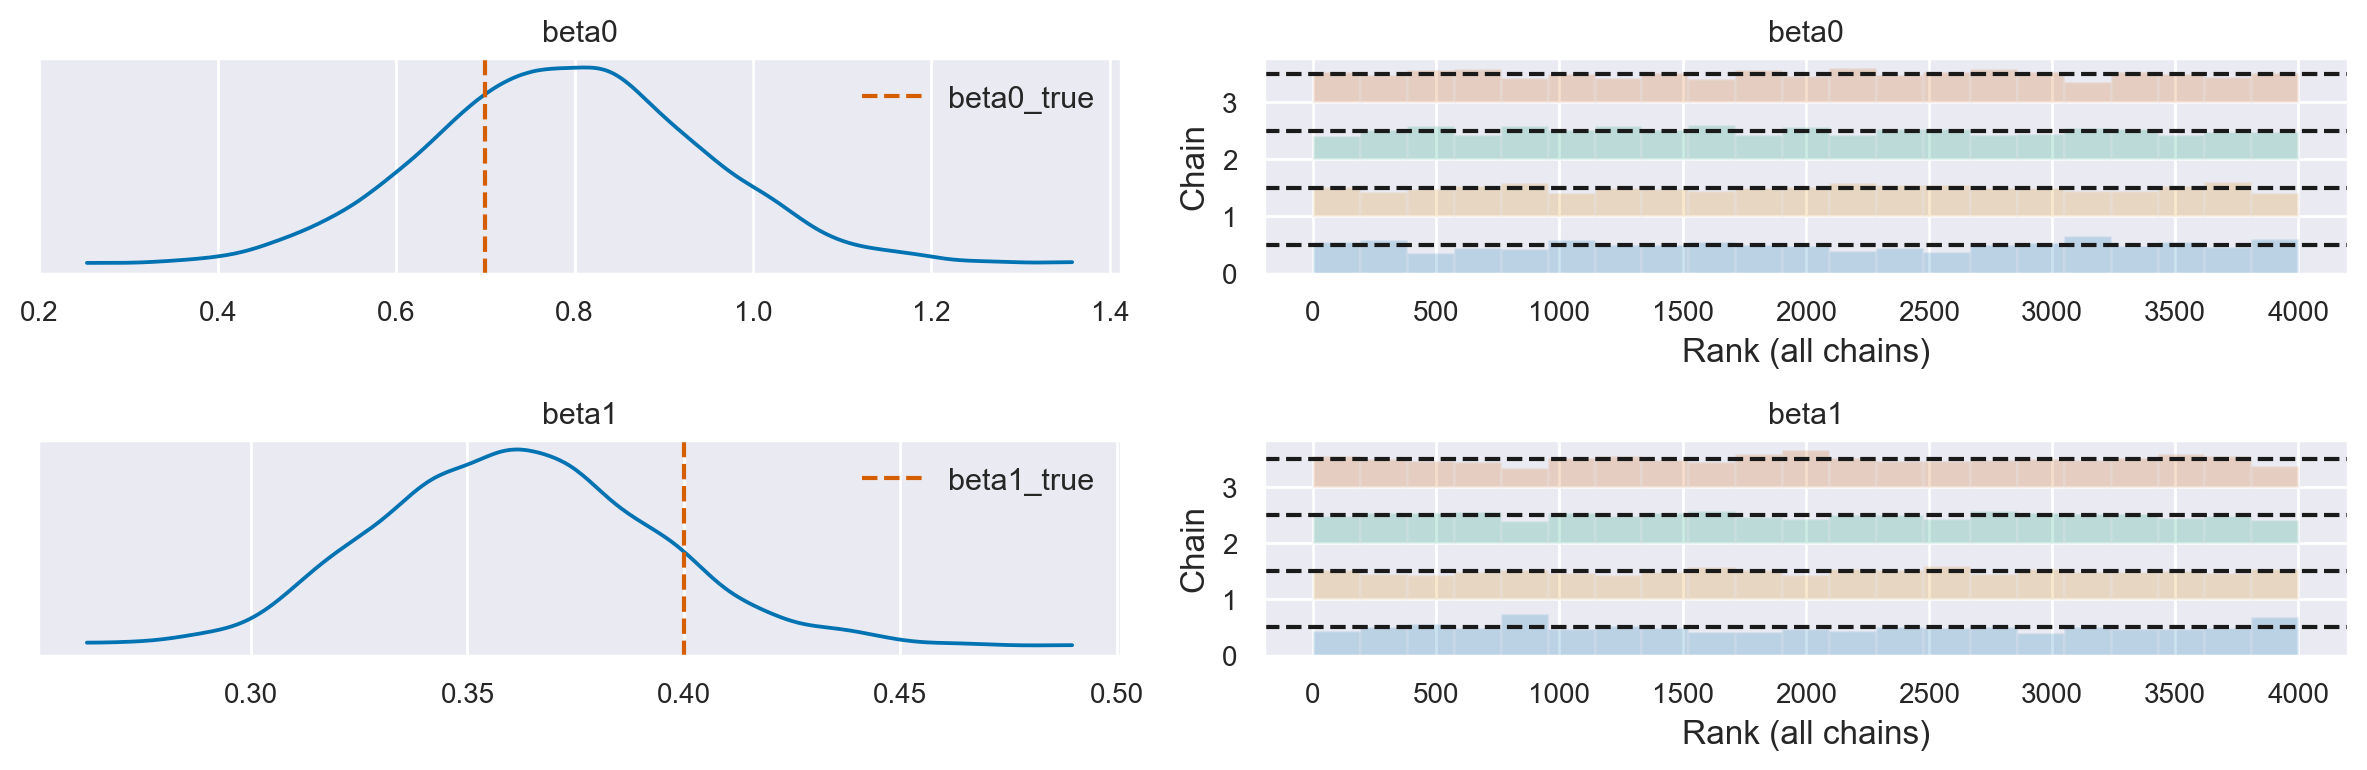

In [9]:
axes = az.plot_trace(idata, combined=True, kind="rank_bars", var_names=["beta0", "beta1"])

# Aggiungi una linea verticale per beta0_true al pannello della densità del kernel per beta0
axes[0][0].axvline(beta0_true, color='r', linestyle='--', label='beta0_true')
axes[0][0].legend()

# Aggiungi una linea verticale per beta1_true al pannello della densità del kernel per beta1
axes[1][0].axvline(beta1_true, color='r', linestyle='--', label='beta1_true')
axes[1][0].legend()

plt.tight_layout()

In [10]:
az.summary(idata, var_names=["beta0", "beta1"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.789,0.152,0.511,1.079,0.003,0.002,2627.0,2332.0,1.0
beta1,0.361,0.032,0.301,0.419,0.001,0.000,2442.0,2513.0,1.0


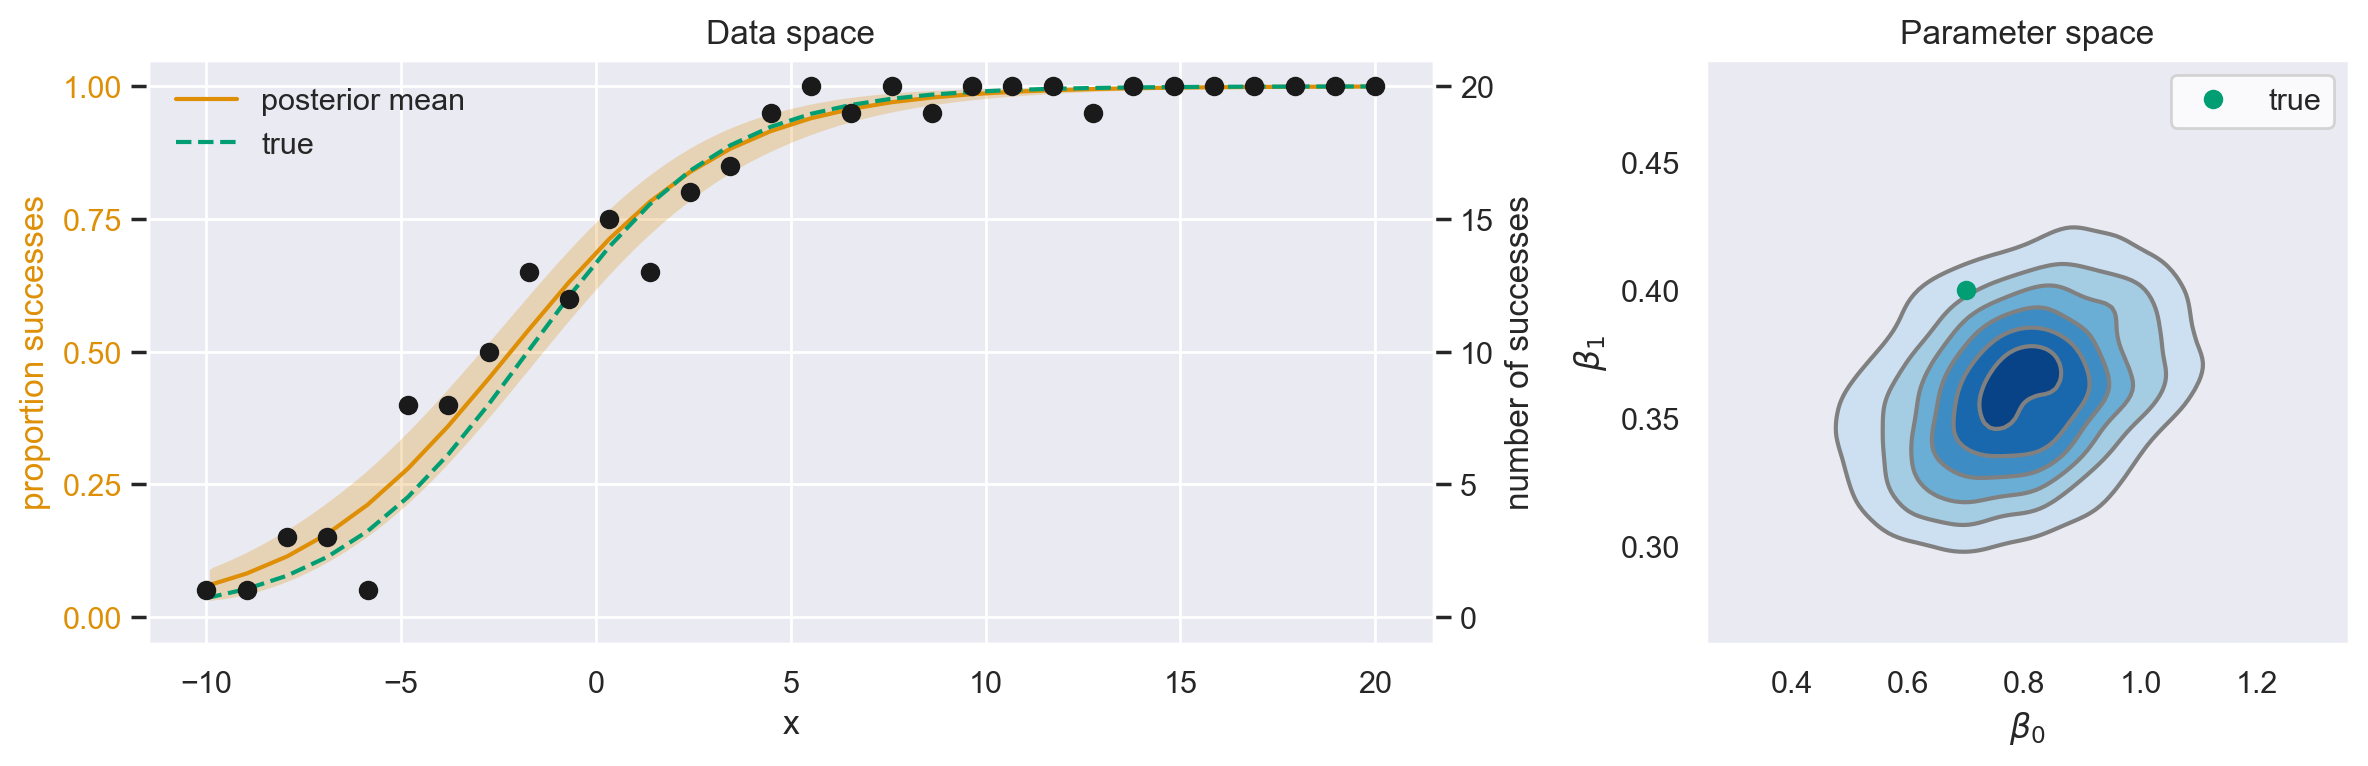

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)
plt.tight_layout()

In [12]:
%run ../wtrmrk.py

Watermark:
----------
Last updated: 2024-01-26T18:47:54.105978+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


